In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from matplotlib.pyplot import plot, scatter, show
from pandas.io.data import DataReader
from datetime import datetime

/Users/davekensinger/anaconda/lib/python3.5/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
%matplotlib inline

In [3]:
start = datetime(2013,9,1)
end = datetime.today()

# stock list
L = ['AAPL', 'SBUX', 'AMZN', 'DIS', 'BRK-B']

#set up DataFrames
daily_price  = pd.DataFrame(index=pd.bdate_range(start, end)) # business days
daily_return = pd.DataFrame(index=pd.bdate_range(start, end))

In [4]:
# get daily equity "Adj Close" from start to end
# would like to build a database of SP500 stocks instead

daily_price = DataReader(L, 'yahoo', start, end)['Adj Close']

daily_return = np.log(1+daily_price.pct_change())  # for a continuous return number
# cumulative_return = daily_return.cumsum()        useful for a normalized return chart

In [5]:
# create expected return vector, stdev vector and covariance, correlation matrices

R = daily_return.mean() # expected return vector
AAR = (1+R)**250-1      # average annual return vector
S = daily_return.std()  # expected standard deviation vector
C = daily_return.cov()  # covariance matrix
Corr =  daily_return.corr() # and a correlation matrix for info

In [6]:
np.matrix(C)

matrix([[  2.38545568e-04,   9.04429117e-05,   5.88162792e-05,
           6.52229012e-05,   7.32301414e-05],
        [  9.04429117e-05,   4.12321005e-04,   7.04094004e-05,
           9.41025717e-05,   1.26135043e-04],
        [  5.88162792e-05,   7.04094004e-05,   9.23628864e-05,
           6.86204231e-05,   6.53507859e-05],
        [  6.52229012e-05,   9.41025717e-05,   6.86204231e-05,
           1.55055742e-04,   7.76239744e-05],
        [  7.32301414e-05,   1.26135043e-04,   6.53507859e-05,
           7.76239744e-05,   1.66730659e-04]])

In [7]:
R*252 # annualized continuous return

AAPL     0.161712
AMZN     0.327154
BRK-B    0.097918
DIS      0.160219
SBUX     0.164703
dtype: float64

In [8]:
np.exp(R*252)-1 # equivalent average annual return

AAPL     0.175522
AMZN     0.387015
BRK-B    0.102872
DIS      0.173768
SBUX     0.179043
dtype: float64

In [9]:
S*np.sqrt(252) # annualized STD

AAPL     0.245181
AMZN     0.322343
BRK-B    0.152563
DIS      0.197672
SBUX     0.204978
dtype: float64

In [10]:
def port_return(W):
    return np.dot(R, W)
    
def port_var(W):
    return np.dot(W, np.dot(C, W))

In [11]:
# Given risk-free rate, assets returns and covariances, this function calculates
# mean-variance frontier and associated weights

def find_frontier(R, C, rf):
        def fitness(W, R, C, r):
                # For given level of return r, find weights that minimize portfolio variance.
                mean, var = port_return(W), port_var(W)
                # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
                penalty = 50*abs(mean-r)
                return var + penalty
        frontier_mean, frontier_var, frontier_weights = [], [], []
        for r in np.linspace(min(R), max(R), num=20):   # iterate through a range of returns on Y axis
                W = np.ones([len(L)])/len(L)            # start optimization with equal weights
                b_ = [(0.,1.) for i in range(len(L))]
                c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })
                optimized = minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)   
                if not optimized.success: 
                        raise BaseException(optimized.message)
                # add point to the min-var frontier [x,y] = [optimized.x, r]
                frontier_mean.append(r)                                                 # return
                frontier_var.append(np.sqrt(port_var(optimized.x)))   # min-variance based on optimized weights
                frontier_weights.append(optimized.x)
        return np.array(frontier_mean), np.array(frontier_var), frontier_weights

In [12]:
# finds tangential optimum portfolio based on rf input

def tangent_weights(C, rf):
    def Sharpe(W, C, rf):
        mean, var = port_return(W), port_var(W) 
        util = (mean - rf) / np.sqrt(var)               # calculates the Sharpe Ratio
        return 1/util                                   # maximize utility, minimize the function
    W = np.ones([len(L)])/len(L)
    b_ = [(0., 1.) for i in range(len(L))]              # weights between 0 and 100%, no shorts
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })   # weights must add to 100%
    res = minimize(Sharpe, W, (C, rf), method='SLSQP', constraints=c_, bounds=b_) # the magic scipy function!
    if not res.success:
        raise BaseException(res.message)
    return res.x

In [13]:
def min_var_weights(C, rf):
    def mvp(W, C, rf):
        return port_var(W)
    W = np.ones([len(L)])/len(L)
    b_ = [(0., 1.) for i in range(len(L))]              # weights between 0 and 100%, no shorts
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })   # weights must add to 100%
    res = minimize(mvp, W, (C, rf), method='SLSQP', constraints=c_, bounds=b_) # the magic scipy function!
    if not res.success:
        raise BaseException(res.message)
    return res.x

In [14]:
rf = 0.0001

T_W = tangent_weights(C, rf)
MV_W = min_var_weights(C, rf)
F_M, F_S, F_W = find_frontier(R, C, rf)

In [15]:
print('tangential weights:')
for i, stock in enumerate(T_W):
    print('{}      {:.2%}'.format(L[i],stock))
    
print('minimum variance weights:')
for i, stock in enumerate(MV_W):
    print('{}      {:.2%}'.format(L[i],stock))

tangential weights:
AAPL      16.67%
SBUX      43.05%
AMZN      0.00%
DIS      28.55%
BRK-B      11.74%
minimum variance weights:
AAPL      20.00%
SBUX      20.00%
AMZN      20.00%
DIS      20.00%
BRK-B      20.00%


In [16]:
sharpe = (port_return(T_W) - rf) / np.sqrt(port_var(T_W))
mean, std = port_return(T_W), np.sqrt(port_var(T_W))
print('tangent portfolio has a {:.2%} average daily return with a {:.2%} standard deviation'.format(mean, std))
print('This portfolio has a Sharpe ratio of {:.3} using a risk free rate of {:.2}'.format(sharpe,rf))

tangent portfolio has a 0.09% average daily return with a 1.27% standard deviation
This portfolio has a Sharpe ratio of 0.0649 using a risk free rate of 0.0001


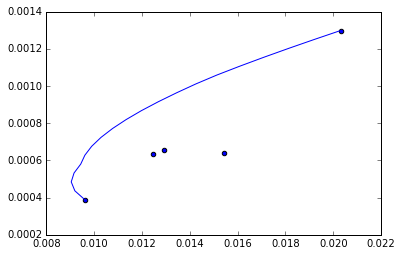

In [17]:
plot(F_S,F_M)
scatter(S,R)
show()

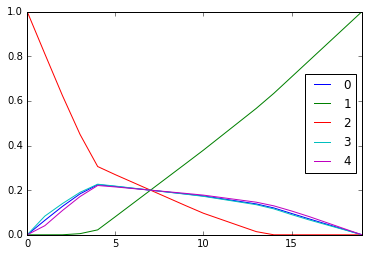

In [18]:
F_W = pd.DataFrame(F_W)
F_W.plot()
show()

In [19]:
W = np.ones([len(L)])/len(L)

In [20]:
port_exp_return = np.exp(port_return(W)*252)-1
port_exp_return = port_return(W)
port_std = np.sqrt(port_var(W)*252)
port_std = port_var(W)
print('equal weight portfolio has a {:.2%} average annual return with a {:.2%} standard deviation'.format(port_exp_return, port_std))

equal weight portfolio has a 0.07% average annual return with a 0.01% standard deviation
